In [1]:
import numpy as np
from numpy.random import RandomState
from numpy.polynomial import Polynomial
from matplotlib import pyplot as plt
from ipywidgets import interact, IntSlider
from scipy.stats.distributions import lognorm, rv_frozen
from pathlib import Path

In [2]:
class GeometricBrownianMotion:
    '''Geometric Brownian Motion.(with optional drift).'''
    def __init__(self, mu: float=0.0, sigma: float=1.0):
        self.mu = mu
        self.sigma = sigma

    def simulate(self, t: np.array, n: int, rnd: np.random.RandomState) \
            -> np.array:
        assert t.ndim == 1, 'One dimensional time vector required'
        assert t.size > 0, 'At least one time point is required'
        dt = np.concatenate((t[0:1], np.diff(t)))
        assert (dt >= 0).all(), 'Increasing time vector required'
        # transposed simulation for automatic broadcasting
        dW = (rnd.normal(size=(t.size, n)).T * np.sqrt(dt)).T
        W = np.cumsum(dW, axis=0)
        return np.exp(self.sigma * W.T + (self.mu - self.sigma**2 / 2) * t).T

    def distribution(self, t: float) -> rv_frozen:
        mu_t = (self.mu - self.sigma**2/2) * t
        sigma_t = self.sigma * np.sqrt(t)
        return lognorm(scale=np.exp(mu_t), s=sigma_t)

In [3]:
use_test_data = False
svg_out_path = None # Path('../talk/img')

if svg_out_path:
    svg_out_path.mkdir(parents=True, exist_ok=True)

if use_test_data:
    t = np.linspace(0, 3, 4)
    r = 0.06
    X = np.array([
            [1.00, 1.09, 1.08, 1.34],
            [1.00, 1.16, 1.26, 1.54],
            [1.00, 1.22, 1.07, 1.03],
            [1.00, 0.93, 0.97, 0.92],
            [1.00, 1.11, 1.56, 1.52],
            [1.00, 0.76, 0.77, 0.90],
            [1.00, 0.92, 0.84, 1.01],
            [1.00, 0.88, 1.22, 1.34]]).T
else:
    r = 0.02
    sigma = 0.15
    gbm = GeometricBrownianMotion(mu=r, sigma=sigma)
    t = np.linspace(0, 5, 12*5)
    rnd = RandomState(seed=1234)
    X = gbm.simulate(t, 50, rnd)

X.shape

(60, 50)

In [4]:
figsize = (8, 6)

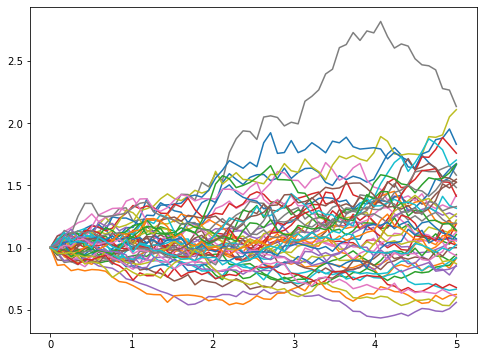

In [5]:
plt.figure(figsize=figsize)
plt.plot(t, X);

if svg_out_path:
    plt.savefig(svg_out_path / 'monte-carlo.svg')

In [6]:
def exercise_value(s):
    return np.maximum(1.1 - s, 0)

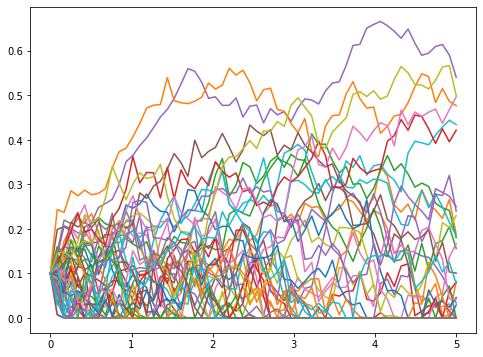

In [7]:
plt.figure(figsize=figsize)
plt.plot(t, exercise_value(X));

if svg_out_path:
    plt.savefig(svg_out_path / 'exercise-value.svg')

In [8]:
cashflow = exercise_value(X[-1, :]) * np.exp(-r * (t[-2]-t[-1]))
p = Polynomial.fit(X[-2, :], cashflow, 2)
p

Polynomial([-0.03283724, -0.19062227,  0.36163981], domain=[0.50897487, 2.26567723], window=[-1.,  1.])

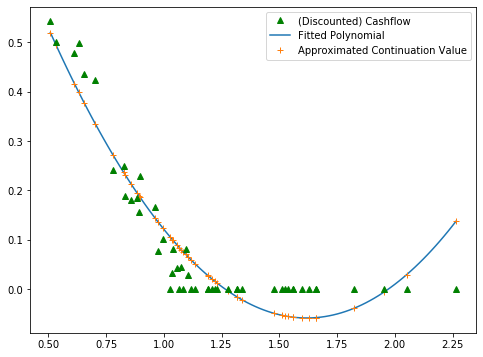

In [9]:
plt.figure(figsize=figsize)
plt.plot(X[-2, :], cashflow, 'g^', zorder=3);
plt.plot(*p.linspace(), zorder=1);
plt.plot(X[-2, :], p(X[-2, :]), '+', zorder=2);
plt.legend(['(Discounted) Cashflow',
            'Fitted Polynomial',
            'Approximated Continuation Value'])

if svg_out_path:
    plt.savefig(svg_out_path / 'continuation-value-approximation.svg')

In [10]:
intermediate_results = []

# given no prior exercise we just receive the payoff of a European option
cashflow = exercise_value(X[-1, :])
# iterating backwards in time 
for i in reversed(range(1, X.shape[0] - 1)):
    # discount factor between t[i] and t[i+1]
    df = np.exp(-r * (t[i+1]-t[i]))
    # discount cashflows from next period
    cashflow = cashflow * df
    x = X[i, :]
    # boolean index of all in-the-money paths
    itm = exercise_value(x) > 0
    # fit polynomial of degree 2
    fitted = Polynomial.fit(x[itm], cashflow[itm], 2)
    # approximate continuation value
    continuation = fitted(x)
    # exercise value for time t[i]
    exercise = exercise_value(x)
    # boolean index where exercise is beneficial
    ex_idx = itm & (exercise > continuation)
    # update cashflows with early exercises
    cashflow[ex_idx] = exercise[ex_idx]
    
    intermediate_results.append((cashflow, x, fitted, continuation, exercise, ex_idx))

In [11]:
def running_min_max(*array_seq):
    minimum, maximum = None, None
    for a in array_seq:
        cmin, cmax = a.min(), a.max()
        if minimum is None or cmin < minimum:
            minimum = cmin
        if maximum is None or cmax < maximum:
            maximum = cmax
    return minimum, maximum

In [12]:
grey = '#dddddd'

def plot_approx_n(n_steps, ax):
    cashflow, x, fitted, continuation, exercise, ex_idx = intermediate_results[n_steps]
    fitted_x, fitted_y = fitted.linspace()
    y_min, y_max = running_min_max(cashflow, exercise, fitted_y)
    offset = 0.1 * (y_max - y_min)
    ax.set_ylim((y_min - offset, y_max + offset))
    ax.plot(x, cashflow, '^', color='green', zorder=3);
    ax.plot(x[ex_idx], exercise[ex_idx], 'x', color='red', zorder=5);
    ax.plot(x[~ex_idx], exercise[~ex_idx], 'x', color=grey, zorder=4);
    ax.plot(fitted_x, fitted_y, zorder=2);
    _x = np.linspace(np.min(x), np.max(x))
    ax.plot(_x, fitted(_x), '--', color=grey, zorder=1);
    ax.legend(['(Discounted) Cashflow',
               'Favourable Exercise',
               'Unfavourable Exercise',
               'Approx. of Continuation Value',
               'Out-of-the-money Continuation Value'])

In [13]:
@interact(n_steps=IntSlider(min=0, max=len(intermediate_results)-1, value=14))
def step(n_steps):
    fig, ax = plt.subplots()
    fig.set_figwidth(figsize[0])
    fig.set_figheight(figsize[1])
    plot_approx_n(n_steps, ax)


interactive(children=(IntSlider(value=14, description='n_steps', max=57), Output()), _dom_classes=('widget-int…

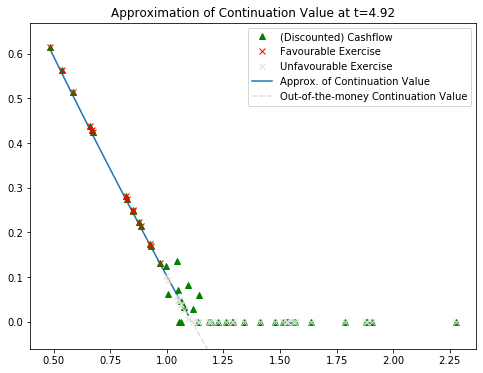

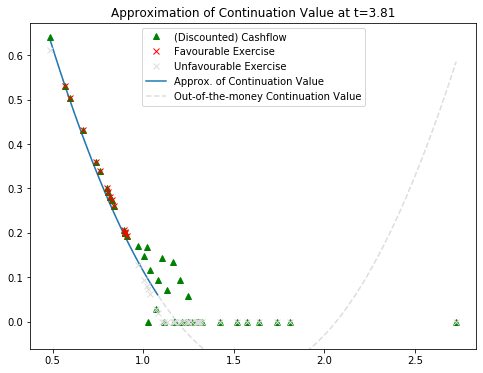

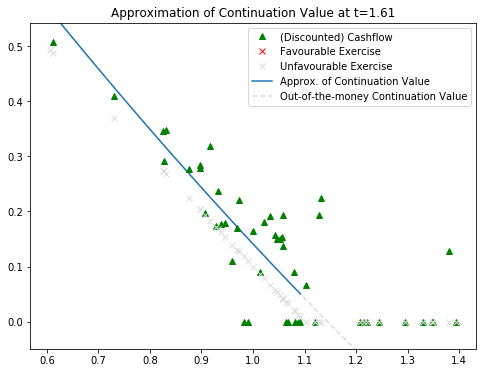

In [14]:
indices = [0, 1] if use_test_data else [1, 14, 40]

for n, i in enumerate(indices):
    fig, ax = plt.subplots()
    fig.set_figwidth(figsize[0])
    fig.set_figheight(figsize[1])
    plot_approx_n(i, ax)
    ax.set_title(f'Approximation of Continuation Value at t={t[-i-1]:0.2f}')

    if svg_out_path:
        plt.savefig(svg_out_path / f'approximated-continuation-and-exercise-value-{n}.svg')

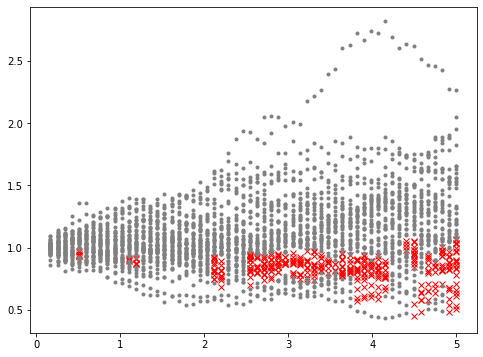

In [15]:
exercise_times = []
exercises = []
non_exercise_times = []
non_exercises = []
for i, (cashflow, x, fitted, continuation, exercise, ex_idx) in enumerate(intermediate_results):
    for ex in x[ex_idx]:
        exercise_times.append(t[-i-1])
        exercises.append(ex)
    for ex in x[~ex_idx]:
        non_exercise_times.append(t[-i-1])
        non_exercises.append(ex)

plt.figure(figsize=figsize)
plt.plot(exercise_times, exercises, 'rx');
plt.plot(non_exercise_times, non_exercises, '.', color='grey');

if svg_out_path:
    plt.savefig(svg_out_path / 'exercise-or-hold.svg')

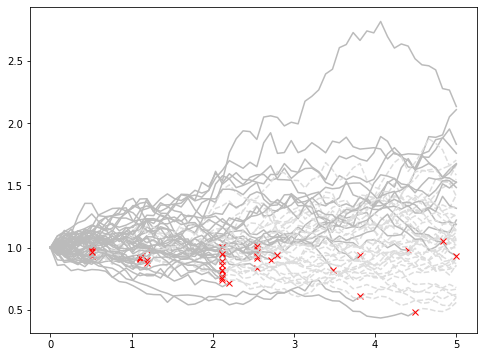

In [16]:
n_timesteps, n_paths = X.shape
first_exercise_idx = n_timesteps * np.ones(shape=(n_paths,), dtype='int')
for i, (cashflow, x, fitted, continuation, exercise, ex_idx) in enumerate(intermediate_results):
    for ex in x[ex_idx]:
        idx_now = (n_timesteps - i - 1) * np.ones(shape=(n_paths,), dtype='int')
        first_exercise_idx[ex_idx] = idx_now[ex_idx]

plt.figure(figsize=figsize)
for i in range(n_paths):
    plt.plot(t[0:first_exercise_idx[i]+1], X[0:first_exercise_idx[i]+1, i], '-', color='#bbbbbb');
    plt.plot(t[first_exercise_idx[i]:], X[first_exercise_idx[i]:, i], '--', color=grey);
    if first_exercise_idx[i] < n_timesteps:
        plt.plot(t[first_exercise_idx[i]], X[first_exercise_idx[i], i], 'rx');

if svg_out_path:
    plt.savefig(svg_out_path / 'first-exercises.svg')

In [17]:
df = np.exp(-r * (t[1]-t[0]))
cashflow = cashflow * df
european_cashflow = exercise_value(X[-1, :]) * np.exp(-r * (t[-1]-t[0]))

In [18]:
assert np.average(cashflow) >= np.average(european_cashflow)
print(np.round(np.average(cashflow), 4))
print(np.round(np.average(european_cashflow), 4))

0.1612
0.0898


In [19]:
if use_test_data:
    assert np.round(np.average(cashflow), 4) == 0.1144
    assert np.round(np.average(european_cashflow), 4) == 0.0564